# Fisher formalism to forecast kSZ SNR.

### Parameters constrained: 6 \$\Lambda{\rm CDM}$ + A$_{\rm kSZ}$.

#### Noise + foreground residuals: tSZ-free x CIB-free cross-ILC from, for example, publish/data/ilc_weights_residuals_agora_fg_model.npy

In [270]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [271]:
import numpy as np, sys, os, scipy as sc, warnings
import tools
import matplotlib.cbook
import scipy.ndimage as ndimage
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

#%pylab notebook
%matplotlib inline
from pylab import *


In [272]:
rcParams['figure.dpi'] = 150
rcParams['figure.facecolor'] = 'white'


In [273]:
#get the ILC residuals first
which_fg_model = 'agora'

fname = 'publish/data/ilc_weights_residuals_%s_fg_model.npy' %(which_fg_model)
ilc_dict = np.load(fname, allow_pickle = True).item()
print(ilc_dict.keys())

#get experiment Nl_dict
nl_TP_dict = ilc_dict['nl_TP_dict']

#different types of ILC considered
ilc_keyname_arr = ilc_dict['ilc_keyname_arr']
print(ilc_keyname_arr)

#ILC weights
weights_dict = ilc_dict['weights']
print(weights_dict.keys())

#total ILC residuals
total_ilc_residuals_dict = ilc_dict['total_ilc_residuals']
print(total_ilc_residuals_dict.keys())

if (1): #with CCAT-prime
    fname_withccatp = 'publish/data/ilc_weights_residuals_%s_fg_model_withccatphfnoisescaledby5.0.npy' %(which_fg_model)
    ilc_dict_withccatp = np.load(fname_withccatp, allow_pickle = True).item()
    cib_plus_tsz_ilc_residuals_dict_withccatp = ilc_dict_withccatp['cib_plus_tsz_residuals']
    print(ilc_dict_withccatp.keys())

#el range
els = ilc_dict['el']

dict_keys(['weights', 'total_ilc_residuals', 'cib_plus_tsz_residuals', 'cib_residuals', 'tsz_residuals', 'noise_residuals', 'radio_residuals', 'nl_TP_dict', 'cl_signal_plus_noise', 'ilc_keyname_arr', 'el'])
['mv' 'tszfree' 'cibfree' 'mvxcibfree' 'mvxtszfree' 'tszfreexcibfree']
dict_keys(['s4_wide'])
dict_keys(['s4_wide'])
dict_keys(['weights', 'total_ilc_residuals', 'cib_plus_tsz_residuals', 'cib_residuals', 'tsz_residuals', 'cl_signal_plus_noise', 'ilc_keyname_arr', 'el'])


In [274]:
#experiment names and fsky values
exp_specs_dict = {'s4_wide': ['S4-Wide', 0.57], 
                  's4_deep': ['S4-Ultra Deep', 0.03], 
                  'spt3g': ['SPT-3G', 0.03],
                  'spt4': ['SPT-3G+SPT-4', 0.03],
                  'so_baseline': ['SO-Baseline', 0.4],
                  'so_goal': ['SO-Goal', 0.4]}

#experiment ordering
exparr = ['spt3g', 'spt4', 'so_baseline', 'so_goal', 's4_wide', 's4_deep']

#ILC keynames
ilc_keyname_dict = {'mv':'MV', 'tszfree': 'tSZ-free', 'cibfree': 'CIB-free'}

In [275]:
#some variables for Fisher forecasting
expname = 's4_wide'
fsky = exp_specs_dict[expname][1]
camb_folder = 'publish/data/CAMB/'
which_spectra = 'lensed'
reqd_ilc_keyname_1 = 'tszfree'
reqd_ilc_keyname_2 = 'cibfree'
if reqd_ilc_keyname_1 != reqd_ilc_keyname_2:
    reqd_ilc_keyname_12 = '%sx%s' %(reqd_ilc_keyname_1, reqd_ilc_keyname_2)
else:
    reqd_ilc_keyname_12 = reqd_ilc_keyname_1

#ksz-related stuffs.
dl_ksz_amp_total = 3. #D_{\ell}^{\rm kSZ} = 3 uK^2 
Aksz = 1. #Amplitude of kSZ.
Aksz_step = Aksz / 100. #stpe for derivative calculation

#parameters for constraining/fixing, power spectra to be used, \ell ranges and priors.
pspectra_to_use = ['TT', 'EE', 'TE']
min_l_pol, max_l_pol = 30, 5000
min_l_temp = 30
max_l_temp = 3000
fix_params = ['mnu', 'ws', 'neff']# but curretnly nothing to fix as we only have a 6+1(neff) LCDM model
prior_dic = {'tau':0.007}#, 'Akszh': dl_ksz_amp_homo/10.}#02}#02} #Planck tau prior


if expname in ['s4_wide', 's4_deep', 'so_baseline', 'so_goal']:
    bands = [95, 150, 220, 285]
elif expname == 'spt3g':
    bands = [95, 150, 220]#, 600, 857]
elif expname == 'spt4':
    bands = [95, 150, 220, 285, 345]


In [276]:
#Temperature ILC residuals for Nl
print('get ILC residuals for Nl')
els, total_ilc_residual_mv = total_ilc_residuals_dict[expname]['mv']
els, total_ilc_residual_1 = total_ilc_residuals_dict[expname][reqd_ilc_keyname_1]
els, total_ilc_residual_2 = total_ilc_residuals_dict[expname][reqd_ilc_keyname_2]
els, total_ilc_residual_12 = total_ilc_residuals_dict[expname][reqd_ilc_keyname_12]
dl_fac = els * (els+1)/2/np.pi

get ILC residuals for Nl


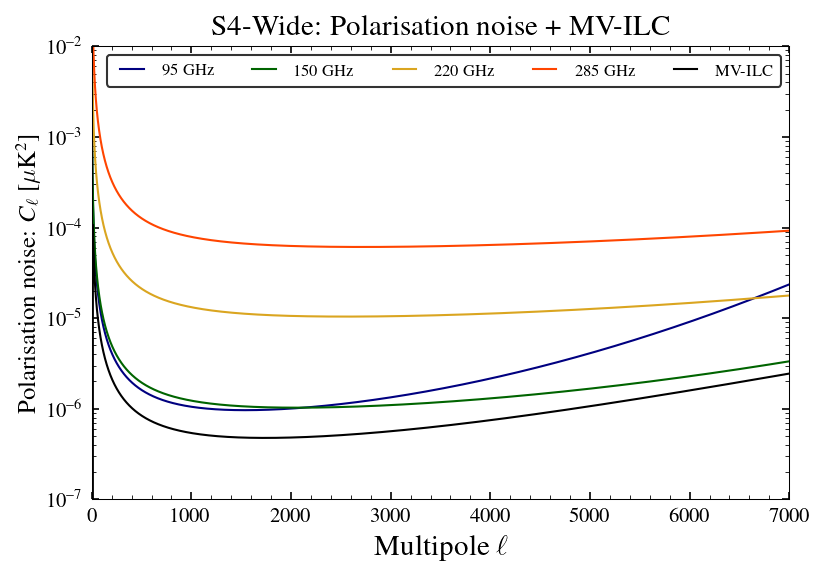

In [277]:
#get MV-ILC for polarisation
"""
Note that foregrounds are assumed to be unpolarised here.
So this should simply be a MV noise estimate after taking beams into account.
"""
import ilc
dict_for_ilc = {}
dict_for_ilc['EE'] = nl_TP_dict[expname]['P']
bands = np.asarray( [95, 150, 220, 285] )
mvilc_pol_residuals, mvilc_pol_weights = ilc.get_mvilc_residual_and_weights(bands, els, dict_for_ilc)
mvilc_pol_residuals = mvilc_pol_residuals[0]

if (1): #show plot for MV-ILC for pol and compare that will noise.
    clf()
    fsval = 14
    band_color_dict = {95: 'navy', 150: 'darkgreen', 220: 'goldenrod', 285: 'orangered', 345: 'darkred'}
    ax=subplot(111, yscale = 'log')
    noise_arr = []
    for (nu1, nu2) in dict_for_ilc['EE']:
        if nu1 != nu2: continue
        curr_nl = dict_for_ilc['EE'][(nu1, nu2)]
        
        plot(els, curr_nl, color = band_color_dict[nu1], label = r'%s GHz' %(nu1))
        noise_arr.append(curr_nl)
        
    #MV-ILC for pol
    plot(els, mvilc_pol_residuals, color = 'black', label = r'MV-ILC')
    
    if (0): #simple MV noise for pol as a sanity check.
        noise_arr = np.asarray(noise_arr)
        mv_noise_pol = ( np.sum(noise_arr**-2, axis = 0) )**-0.5
        plot(els, mv_noise_pol, color = 'hotpink', lw = 2., ls = '-.', label = r'MV noise for pol.')

    legend(loc = 1, fontsize = fsval - 6, ncol = 5)
    xlabel(r'Multipole $\ell$', fontsize = fsval)
    ylabel(r'Polarisation noise: $C_{\ell}$ [$\mu$K$^{2}$]', fontsize = fsval-2)
    xlim(0., 7000.); ylim(1e-7, .01)
    title_str = r'%s: Polarisation noise + MV-ILC' %(exp_specs_dict[expname][0])
    title(title_str, fontsize = fsval)
    show()


In [278]:
#CMB stuffs
#get fiducual LCDM power spectra computed using CAMB
print('get fiducual LCDM power spectra computed using CAMB')
camb_fname = '%s/cmb_spectra_%s.txt' %(camb_folder, which_spectra)
cl_camb = np.loadtxt(camb_fname)
el_camb = cl_camb[:,0] 
cl_camb_tt = cl_camb[:,1]
dl_fac_camb = el_camb * (el_camb+1)/2/np.pi
cl_dic = {}
cl_dic['TT'] = cl_camb[:,1]
cl_dic['EE'] = cl_camb[:,2]
cl_dic['TE'] = cl_camb[:,3]

#get derivatives of CMB power spectrum for different LCDM parameters.
#They are already computed and stored.
print('get/read derivatives')
camb_deriv_fname = '%s/cmb_spectra_derivs_%s.npy' %(camb_folder, which_spectra.replace('_scalar',''))
cl_deriv_dic_tmp = np.load(camb_deriv_fname, allow_pickle = 1).item()
cl_deriv_dic = {}
param_names = []
for p in sorted( cl_deriv_dic_tmp ):
    if p == 'ell': continue
    cl_deriv_dic[p]={}
    cl_deriv_dic[p]['TT'] = cl_deriv_dic_tmp[p][0]
    cl_deriv_dic[p]['EE'] = cl_deriv_dic_tmp[p][1]
    cl_deriv_dic[p]['TE'] = cl_deriv_dic_tmp[p][2]
    param_names.append( p )
    
#interpolate CAMB spectra / derivatives on the desired els.
for which_spec in cl_dic:
    cl_dic[which_spec] = np.interp(els, el_camb, cl_dic[which_spec])
for p in sorted( param_names ):
    for which_spec in cl_deriv_dic[p]:
        cl_deriv_dic[p][which_spec] = np.interp(els, el_camb, cl_deriv_dic[p][which_spec])

get fiducual LCDM power spectra computed using CAMB
get/read derivatives


In [279]:
#kSZ stuffs
#get kSZ spectrum now: Flat D_{\ell}^{\rm kSZ} = 3 uK^2 
cl_ksz = tools.get_cl_ksz(els, Aksz = Aksz, dl_ksz_amp_total = dl_ksz_amp_total)

#add kSZ to cl_dic['TT']
cl_dic['TT'] += cl_ksz

#get deriviatives for Aksz
cl_ksz_low = tools.get_cl_ksz(els, Aksz = Aksz - Aksz_step, dl_ksz_amp_total = dl_ksz_amp_total)
cl_ksz_high = tools.get_cl_ksz(els, Aksz = Aksz + Aksz_step, dl_ksz_amp_total = dl_ksz_amp_total)
cl_deriv_dic['Aksz'] = {}
cl_deriv_dic['Aksz']['TT'] = (cl_ksz_high-cl_ksz_low)/( 2 * Aksz_step)
cl_deriv_dic['Aksz']['EE'] = cl_deriv_dic['Aksz']['TT'] * 0.
cl_deriv_dic['Aksz']['TE'] = cl_deriv_dic['Aksz']['TT'] * 0.

#add Aksz to param_name
param_names.append('Aksz')

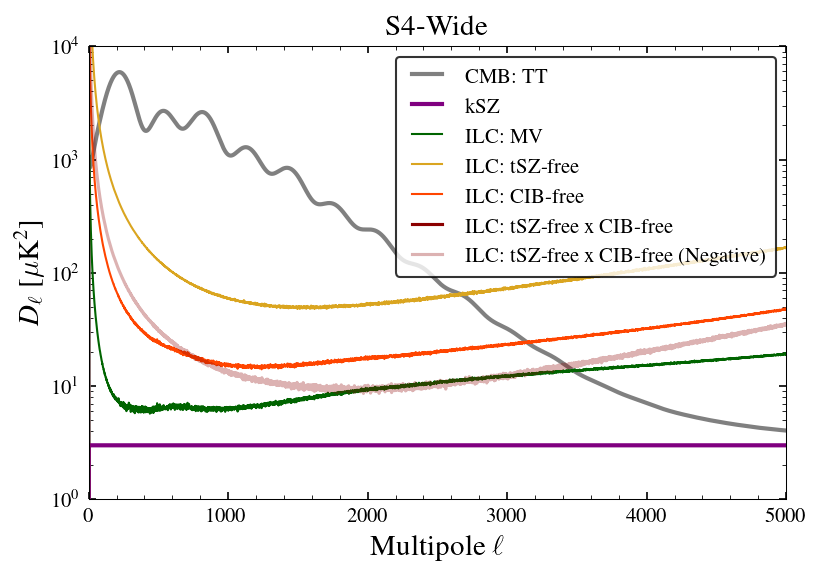

In [280]:
if (1): #show ILC residuals, CMB, and kSZ spectra
    clf()
    fsval = 14
    ax = subplot(111, yscale = 'log')
    plot(els, dl_fac * cl_dic['TT'], label = r'CMB: TT', lw = 2., color = 'gray')
    plot(els, dl_fac * cl_ksz, label = r'kSZ', lw = 2., color = 'purple')
    plot(els, dl_fac * total_ilc_residual_mv, label = r'ILC: MV', color = 'darkgreen')
    plot(els, dl_fac * total_ilc_residual_1, label = r'ILC: %s' %(ilc_keyname_dict[reqd_ilc_keyname_1]), color = 'goldenrod')
    plot(els, dl_fac * total_ilc_residual_2, label = r'ILC: %s' %(ilc_keyname_dict[reqd_ilc_keyname_2]), color = 'orangered')
    if (1): #cross-ILC
        plot(els, dl_fac * total_ilc_residual_12, lw = 1.5, label = r'ILC: %s x %s' %(ilc_keyname_dict[reqd_ilc_keyname_1], ilc_keyname_dict[reqd_ilc_keyname_2]), color = 'darkred')
        plot(els, dl_fac * -total_ilc_residual_12, lw = 1.5, alpha = 0.3, color = 'darkred', label = r'ILC: %s x %s (Negative)' %(ilc_keyname_dict[reqd_ilc_keyname_1], ilc_keyname_dict[reqd_ilc_keyname_2]))
    
    xlabel(r'Multipole $\ell$', fontsize = fsval)
    ylabel(r'$D_{\ell}$ [$\mu$K$^{2}$]', fontsize = fsval)
    xlim(0., 5000.); ylim(1., 1e4)
    legend(loc = 1, fontsize = fsval-4)
    title(r'%s' %(exp_specs_dict[expname][0]), fontsize = fsval)
    show()

In [281]:
#get delta_Cl using Knox formula.
nl11_dic = {}
nl11_dic['TT'] = total_ilc_residual_1
nl11_dic['EE'] = mvilc_pol_residuals
nl11_dic['TE'] = np.copy(total_ilc_residual_1) * 0.

nl22_dic = {}
nl22_dic['TT'] = total_ilc_residual_2
nl22_dic['EE'] = mvilc_pol_residuals
nl22_dic['TE'] = np.copy(total_ilc_residual_2) * 0.

nl12_dic = {}
nl12_dic['TT'] = total_ilc_residual_12
nl12_dic['EE'] = mvilc_pol_residuals
nl12_dic['TE'] = np.copy(total_ilc_residual_12) * 0.

delta_cl_dic = tools.get_knox_errors_parent(els, cl_dic, nl11_dic, fsky, nl22_dic = nl22_dic, nl12_dic = nl12_dic)
print(delta_cl_dic.keys())

if (1): #MV ILC
    nl_mv_dic = {}
    nl_mv_dic['TT'] = total_ilc_residual_mv
    nl_mv_dic['EE'] = mvilc_pol_residuals
    nl_mv_dic['TE'] = np.copy(total_ilc_residual_mv) * 0.
    delta_cl_dic_mv = tools.get_knox_errors_parent(els, cl_dic, nl_mv_dic, fsky)
    print(delta_cl_dic_mv.keys())

dict_keys(['TT', 'EE', 'TE'])
dict_keys(['TT', 'EE', 'TE'])


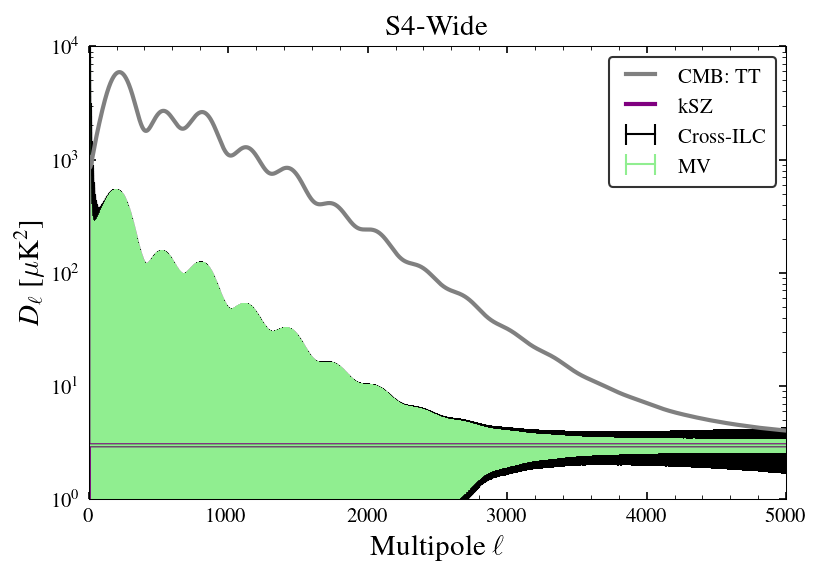

In [282]:
if (1): #show ILC residuals, CMB, and kSZ spectra
    clf()
    fsval = 14
    ax = subplot(111, yscale = 'log')
    plot(els, dl_fac * cl_dic['TT'], label = r'CMB: TT', lw = 2., color = 'gray')
    plot(els, dl_fac * cl_ksz, label = r'kSZ', lw = 2., color = 'purple')

    delta_cl = delta_cl_dic['TT']
    errorbar(els, dl_fac * cl_ksz, yerr = dl_fac * delta_cl, color = 'black', label = 'Cross-ILC')

    delta_cl_mv = delta_cl_dic_mv['TT']
    errorbar(els, dl_fac * cl_ksz, yerr = dl_fac * delta_cl_mv, color = 'lightgreen', label = 'MV')
    
    if (0):
        tmp = tools.get_knox_errors(els, cl_dic['TT'] + total_ilc_residual_mv, fsky, cl22 = None, cl12 = None)
        tmp2 = tools.get_knox_errors(els, cl_dic['TT'] + total_ilc_residual_1, fsky, cl22 = cl_dic['TT'] + total_ilc_residual_2, cl12 = cl_dic['TT'] + total_ilc_residual_12)
        errorbar(els, dl_fac * cl_ksz, yerr = dl_fac * tmp2, color = 'goldenrod' )
        errorbar(els, dl_fac * cl_ksz, yerr = dl_fac * tmp, color = 'red' )

    xlabel(r'Multipole $\ell$', fontsize = fsval)
    ylabel(r'$D_{\ell}$ [$\mu$K$^{2}$]', fontsize = fsval)
    xlim(0., 5000.); ylim(1., 1e4)
    legend(loc = 1, fontsize = fsval-4)
    title(r'%s' %(exp_specs_dict[expname][0]), fontsize = fsval)
    show()

In [285]:
#get Fisher / COV matrices
desired_param = 'Aksz'
print('\tget fisher')
max_l_temp_arr = [2000, 3000, 3500, 4000, 4500, 5000]
delta_cl_dic_arr = [delta_cl_dic_mv, delta_cl_dic]
delta_cl_dic_str_arr = ['MV', 'cross-ILC']
for curr_delta_cl_dic, curr_delta_cl_dic_str in zip(delta_cl_dic_arr, delta_cl_dic_str_arr):
    print(curr_delta_cl_dic_str)
    
    for max_l_temp in max_l_temp_arr:
        F_mat = tools.get_fisher_matrix(els, cl_deriv_dic, curr_delta_cl_dic, param_names, pspectra_to_use = pspectra_to_use,\
                    min_l_temp = min_l_temp, max_l_temp = max_l_temp, min_l_pol = min_l_pol, max_l_pol = max_l_pol)

        cov_mat = np.linalg.inv(F_mat)
        param_names = np.asarray(param_names)
        pind = np.where(param_names == desired_param)[0][0]
        pcntr1, pcntr2 = pind, pind
        cov_inds_to_extract = [(pcntr1, pcntr1), (pcntr1, pcntr2), (pcntr2, pcntr1), (pcntr2, pcntr2)]
        cov_extract = np.asarray( [cov_mat[ii] for ii in cov_inds_to_extract] ).reshape((2,2))
        sigma_Aksz = cov_extract[0,0]**0.5
        
        snr_Aksz = Aksz/sigma_Aksz
        print(max_l_temp, snr_Aksz )
    

	get fisher
MV
2000 6.071909036803356
3000 34.78097901982975
3500 52.353487814177605
4000 67.33569202370403
4500 84.62577025270568
5000 106.24571440568799
cross-ILC
2000 5.823830880165398
3000 31.088912853493213
3500 45.56383650397107
4000 56.773136656497314
4500 66.50673093488548
5000 75.03595771291796


In [286]:
#get Fisher / COV matrices with all 6 LCDM parameters fixed.
print('\tget fisher')
max_l_temp_arr = [2000, 3000, 3500, 4000, 4500, 5000]
delta_cl_dic_arr = [delta_cl_dic_mv, delta_cl_dic]
delta_cl_dic_str_arr = ['MV', 'cross-ILC']
for curr_delta_cl_dic, curr_delta_cl_dic_str in zip(delta_cl_dic_arr, delta_cl_dic_str_arr):
    print(curr_delta_cl_dic_str)
    
    for max_l_temp in max_l_temp_arr:
        F_mat = tools.get_fisher_matrix(els, cl_deriv_dic, curr_delta_cl_dic, param_names, pspectra_to_use = pspectra_to_use,\
                    min_l_temp = min_l_temp, max_l_temp = max_l_temp, min_l_pol = min_l_pol, max_l_pol = max_l_pol)

        fix_params = param_names[:-1]
        F_mat_mod = np.copy(F_mat)
        F_mat_mod, param_names_mod = tools.fix_params(F_mat_mod, param_names, fix_params)

        cov_mat = np.linalg.inv(F_mat_mod)
        sigma_Aksz = np.sqrt( cov_mat )
        snr_Aksz = Aksz/sigma_Aksz
        print(max_l_temp, snr_Aksz )
    

	get fisher
MV
2000 [[7.00101462]]
3000 [[49.87142162]]
3500 [[101.87620878]]
4000 [[165.06043112]]
4500 [[223.63333003]]
5000 [[272.26309535]]
cross-ILC
2000 [[6.91039183]]
3000 [[43.34957391]]
3500 [[74.1123125]]
4000 [[99.95877861]]
4500 [[118.21883196]]
5000 [[130.55687139]]
